# Demo ConvNet para identificar si Nicolas Cage aparece o no en una foto

1) Cargar librerías:

In [1]:
# nota se debe indicar la versión 1 de TF para compatibilidad del código
%tensorflow_version 1.x

import tensorflow
print(tensorflow.__version__)

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from IPython.display import Image

import os
import os.path

import json
from keras.models import model_from_json
from keras.models import load_model

import numpy as np 
import matplotlib.pyplot as plt

print ("Librerías cargadas.")

TensorFlow 1.x selected.
1.15.2
Librerías cargadas.


Using TensorFlow backend.


2) Cargar imágenes a procesar:

In [2]:
# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoConvNet-NC'

# define los nombres de los archivos a utilizar para leer/grabar el modelo
history_file_name = '/Model/CNN_NC_history_dump_final.json'
weights_file_name = '/Model/CNN_NC_model_final.h5'
model_json_file_name = '/Model/CNN_NC_model_final.json'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# ajusta el tamaño para achicar los valores del RGB (que pasen a ser de 0 a 1 en vez de 0 a 255)
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

# también se resizean las imagenes a 200x200
target_size = (200, 200)
batch_size = 32

# levanta imágenes de entrenamiento
training_set = train_datagen.flow_from_directory("".join([path, '/Dataset/train/']), 
                                                 target_size=target_size, 
                                                 batch_size=batch_size, 
                                                 shuffle=True, 
                                                 class_mode="binary")
# levanta imágenes de prueba
test_set = test_datagen.flow_from_directory("".join([path, '/Dataset/test/']), 
                                            target_size=target_size, 
                                            batch_size=batch_size,  
                                            shuffle=True, 
                                            class_mode="binary")
print(training_set.class_indices)

Found 290 images belonging to 2 classes.
Found 124 images belonging to 2 classes.
{'class0': 0, 'class1': 1}


3) Construye el modelo:

In [4]:
# construye modelo de la nueva ConvNet
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), input_shape = (200, 200, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Flatten())

classifier.add(Dense(units = 64, activation = 'relu'))
classifier.add(Dropout(0.5))

classifier.add(Dense(1))
classifier.add(Activation('sigmoid')) # se usa sigmoidal porque sólo hay 2 clases

# compila el modelo
classifier.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics = ['accuracy'])

# muestra el modelo creado
print(classifier.summary())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 64)        18496     
____________________________________

4) Entrenar el modelo:

In [5]:
# parámetros
steps_per_epoch = len(training_set.filenames)
epochs = 8
validation_steps = steps_per_epoch // 2 

# manda a entrenar el modelo (conviene usar GPU)
history = classifier.fit_generator(training_set, 
                                   steps_per_epoch = steps_per_epoch, 
                                   epochs = epochs, 
                                   validation_data = test_set, 
                                   validation_steps = validation_steps)
h = history.history




Epoch 1/8





290/290 [==============================] - 298s 1s/step - loss: 0.4665 - acc: 0.7807 - val_loss: 0.3819 - val_acc: 0.8714
Epoch 2/8
290/290 [==============================] - 173s 598ms/step - loss: 0.2287 - acc: 0.9272 - val_loss: 0.4686 - val_acc: 0.8463
Epoch 3/8
290/290 [==============================] - 173s 596ms/step - loss: 0.2471 - acc: 0.9184 - val_loss: 0.4220 - val_acc: 0.8468
Epoch 4/8
290/290 [==============================] - 173s 596ms/step - loss: 0.1520 - acc: 0.9533 - val_loss: 0.5795 - val_acc: 0.8711
Epoch 5/8
290/290 [==============================] - 174s 599ms/step - loss: 0.1168 - acc: 0.9639 - val_loss: 0.5286 - val_acc: 0.8783
Epoch 6/8
290/290 [==============================] - 173s 598ms/step - loss: 0.1095 - acc: 0.9650 - val_loss: 0.6323 - val_acc: 0.8552
Epoch 7/8
290/290 [==============================] - 173s 595ms/step - loss: 0.0952 - acc: 0.9741 - val_loss: 0.6917 - val_acc: 0.8790
Epoch 8/8
290/290 [==============================]

*   Graba el modelo entrenado:



In [6]:
# graba el modelo
with open("".join([path, history_file_name]), 'w') as f:
  json.dump(h, f)

classifier.save("".join([path, weights_file_name]))

model_json = classifier.to_json()
with open("".join([path, model_json_file_name]), "w") as json_file:
    json_file.write(model_json)

print("Modelo grabado en ", path, ": [", weights_file_name, "], [", history_file_name, "] y [", model_json_file_name, "] ")

Modelo grabado en  gdrive/My Drive/IA/demoConvNet-NC : [ /Model/CNN_NC_model_final.h5 ], [ /Model/CNN_NC_history_dump_final.json ] y [ /Model/CNN_NC_model_final.json ] 


---
**OPCIONAL**: en lugar de hacer pasos 3 y 4, se puede cargar un modelo ya entrenado y grabado en Drive (si existe). 




In [0]:
# carga modelo ya grabado de ConvNet
if os.path.isfile("".join([path, model_json_file_name])):
    classifier = load_model("".join([path, weights_file_name]))

    if os.path.isfile("".join([path, history_file_name])):
      h = json.load(open("".join([path, history_file_name]), 'r'))
      print("Modelo cargado de ", path, ": [", weights_file_name, "], [", history_file_name, "] y [", model_json_file_name, "] ")
    else: 
      print("No se encuentra modelo para cargar")
else:   
    print("No se encuentra modelo para cargar")

# muestra el modelo cargado
print(classifier.summary())

---

5) Muestra estadísticas y resultados del probar el modelo:

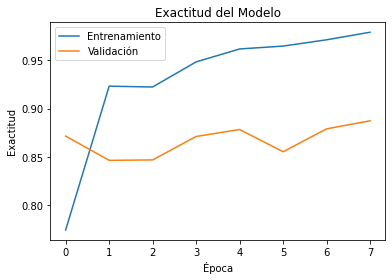

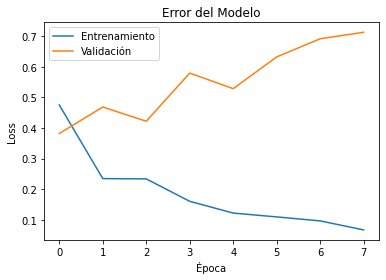

In [7]:
# muestra gráfico de exactitud y loss
plt.plot(h['acc'])
plt.plot(h['val_acc'])
plt.title('Exactitud del Modelo')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.title('Error del Modelo')
plt.ylabel('Loss')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()



>Detalle de resultados de procesar las imágenes de Validación: 


-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_145.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_146.jpg :  NO está Nicolas Cage!


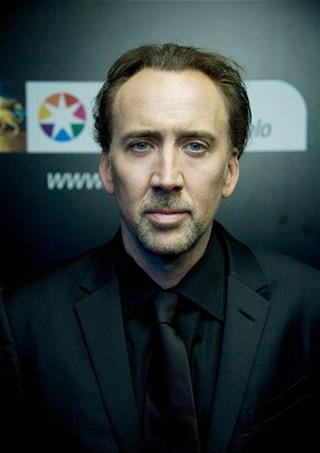

-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_147.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_149.jpg :  NO está Nicolas Cage!


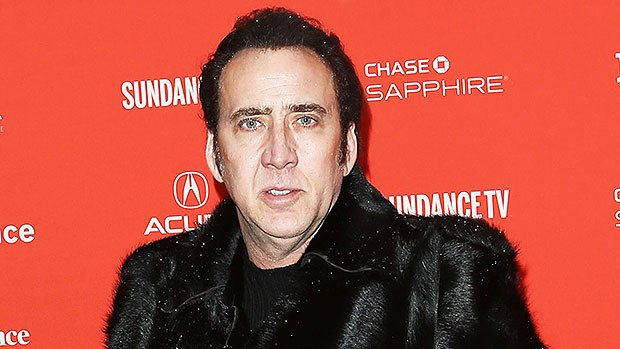

-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_150.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_151.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_153.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_152.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_158.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_154.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_155.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_156.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_161.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_148.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/

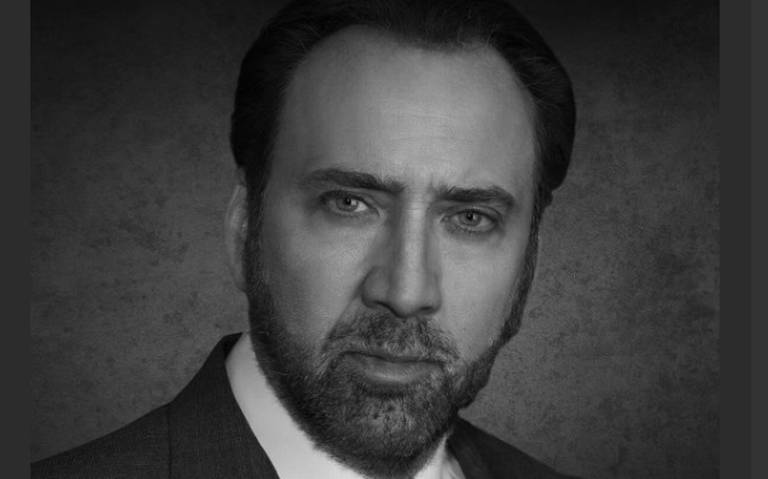

-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_165.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_168.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_169.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_171.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_170.jpg :  NO está Nicolas Cage!


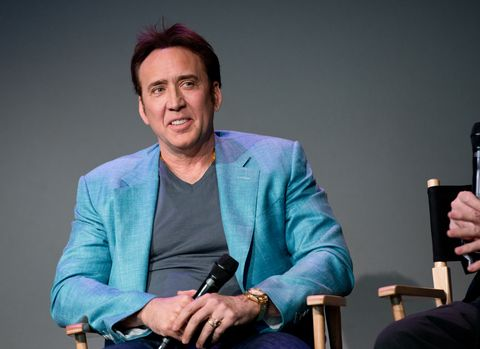

-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_172.jpg :  NO está Nicolas Cage!


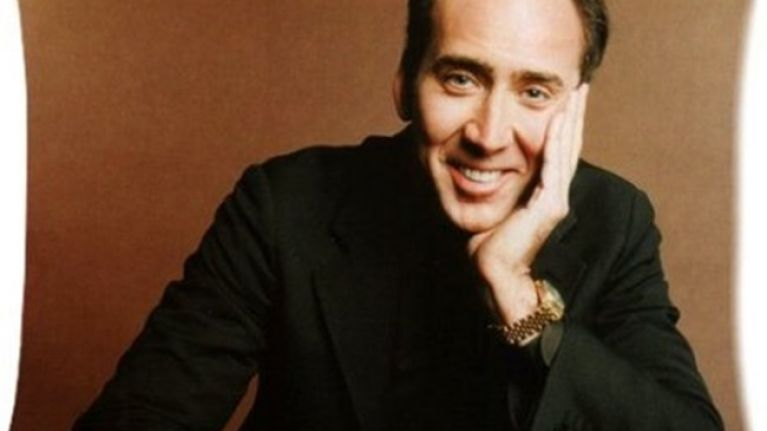

-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_173.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_177.jpg :  NO está Nicolas Cage!


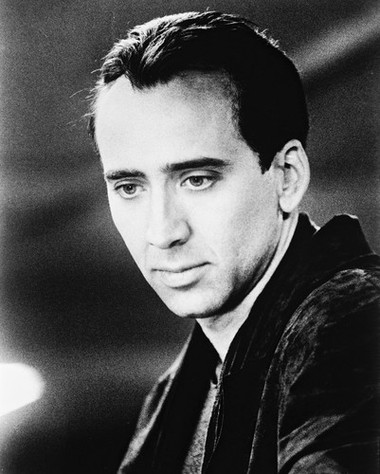

-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_178.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_180.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_179.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_181.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_185.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_182.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_184.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_183.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_186.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_174.jpg :  NO está Nicolas Cage!


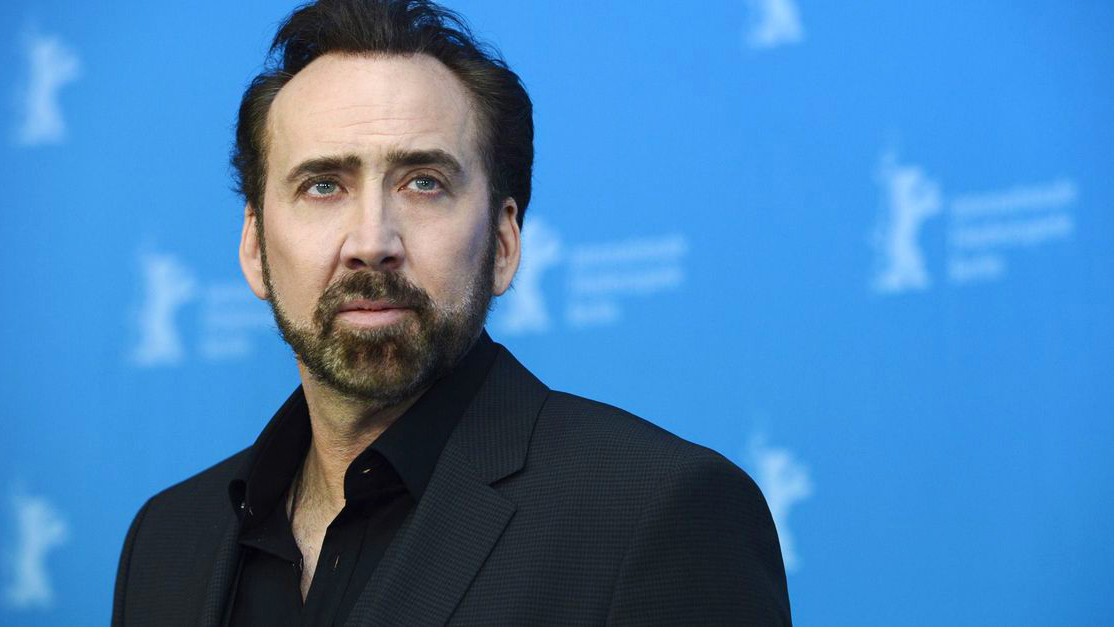

-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_187.jpg :  NO está Nicolas Cage!


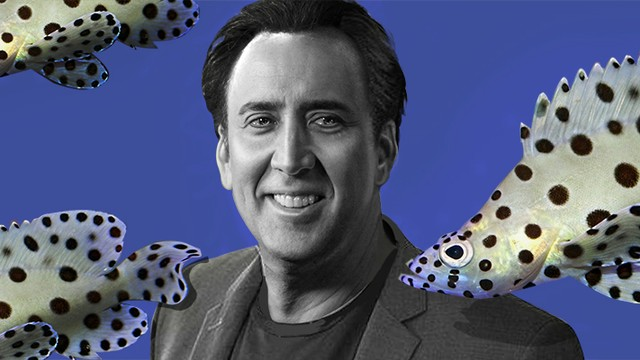

-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_175.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_176.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_188.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_190.jpg :  NO está Nicolas Cage!


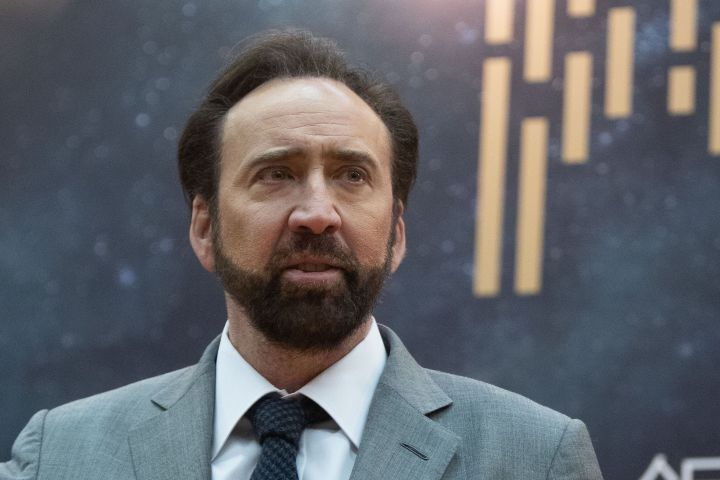

-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_189.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_191.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_192.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_194.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_193.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_195.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_198.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_199.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_196.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_201.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/

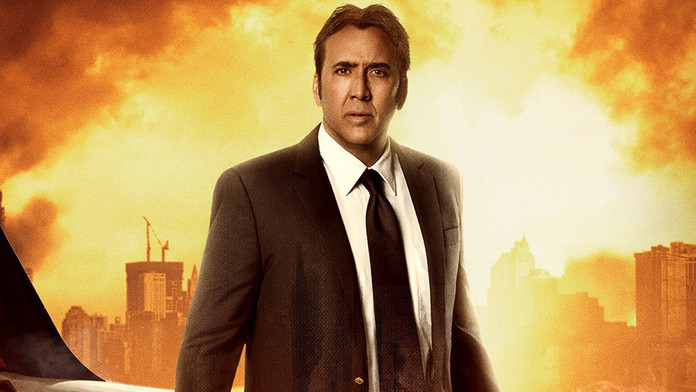

-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_204.jpg :  está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class1/Nic_Cage_205.jpg :  está Nicolas Cage

++ TOTAL CLASS 1 :  61 : Detectado OK  51 imágenes - Detectado con Error  10 imágenes.




-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_148.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_147.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_149.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_150.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_151.jpg :  está Nicolas Cage!


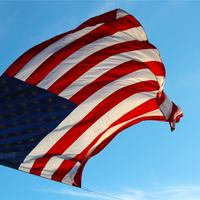

-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_154.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_152.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_153.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_155.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_156.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_157.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_158.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_160.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_159.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_161.jpg :  NO está Nic

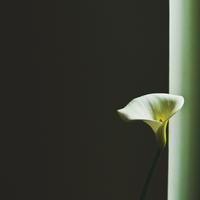

-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_171.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_170.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_174.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_175.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_176.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_177.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_179.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_184.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_183.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_178.jpg :  NO está Nic

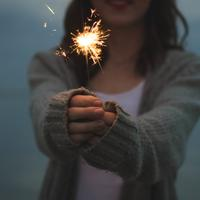

-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_188.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_191.jpg :  está Nicolas Cage!


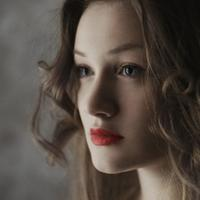

-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_190.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_192.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_193.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_200.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_194.jpg :  está Nicolas Cage!


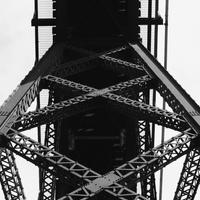

-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_199.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_198.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_201.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_196.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_197.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_195.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_202.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_203.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_204.jpg :  NO está Nicolas Cage
-  gdrive/My Drive/IA/demoConvNet-NC/Dataset/test/class0/not_nicolas_205.jpg :  NO está Nic

In [8]:
print("\n>Detalle de resultados de procesar las imágenes de Validación: ")

# define función auxiliar para mostrar resultado de cada imagen
def testImage(file_name, image_sample, classDesired):
    result = classifier.predict(image_sample)
    prediction = 'está Nicolas Cage' if result[0][0] == 1 else 'NO está Nicolas Cage'
    if result[0][0] == classDesired:
      res = True
    else:
      res = False
      prediction = "".join([prediction, "!"])

    print("- ", file_name,": " , prediction)
    if not res:
      img = Image(file_name, width = "100", height = "100")
      display(img)

    return res

# define función auxiliar para mostrar resultado de cada directorio
def testAllClass(classDesired):
  cantOK = 0
  cantNOK = 0
  predict_path = "".join([path, '/Dataset/test/class', str(classDesired)])
  print("\n")
  for file in os.listdir(predict_path):
      if not file.startswith('.'):
          file = predict_path + "/" + file

          image_sample = image.load_img(file, target_size = (200, 200))
          image_sample = image.img_to_array(image_sample)
          image_sample = np.expand_dims(image_sample, axis = 0)
          
          result = testImage(file, image_sample, classDesired)
          if (result):
            cantOK = cantOK + 1
          else:
            cantNOK = cantNOK + 1

  print("\n++ TOTAL CLASS", classDesired,": ", cantOK+cantNOK, ": Detectado OK ", cantOK, "imágenes - Detectado con Error ", cantNOK, "imágenes.\n\n")
  return cantOK, cantNOK

# procesa las imágenes de la carpeta <Test>
VP = 0
VN = 0
FP = 0
FN = 0
VP, FN = testAllClass(1)
VN, FP = testAllClass(0)

# muestra resultados resumidos
print("\n")
print("> Matríz de Confusión: ")
print("--------------------------------------------")
print("                     ConvNet")
print("   Real        ESTA       NO ESTA")
print("   ESTA         %4d         %4d  " % (VP, FN))
print(" NO ESTA        %4d         %4d  " % (FP, VN))
print("--------------------------------------------")
print("\n")
print("> Exactitud: %3.2f " % (((VP+VN)/(𝑉𝑃+𝐹𝑃+𝑉𝑁+𝐹𝑁))*100))
print("> Precisión: %3.2f " % ((VP/(𝑉𝑃+𝐹𝑃))*100))
print("> Recuperación: %3.2f " % ((VP/(𝑉𝑃+FN))*100))
print("\n")

*) Usar el modelo para predecir usando las imágenes de la carpeta 'Predict':


>  gdrive/My Drive/IA/demoConvNet-NC/Predict/meme.jpg :  está Nicolas Cage


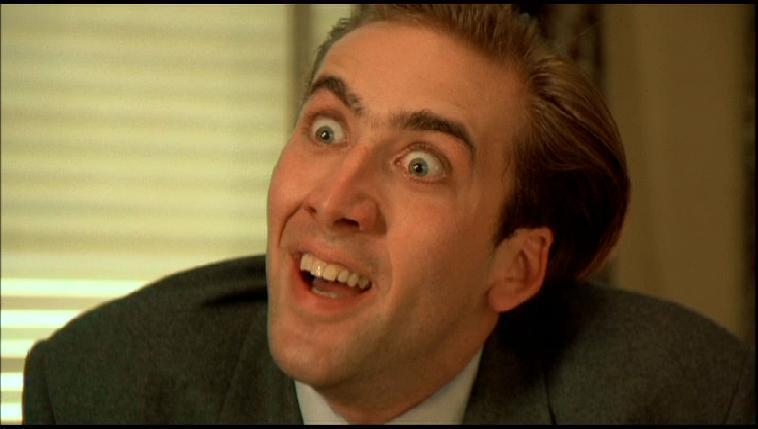




>  gdrive/My Drive/IA/demoConvNet-NC/Predict/mona.jpg :  está Nicolas Cage


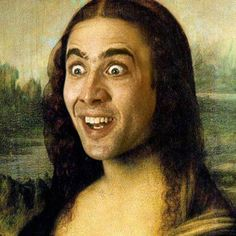




>  gdrive/My Drive/IA/demoConvNet-NC/Predict/mug.jpg :  está Nicolas Cage


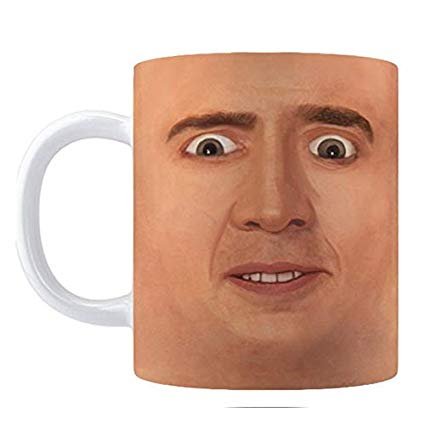




>  gdrive/My Drive/IA/demoConvNet-NC/Predict/independence.jpg :  está Nicolas Cage


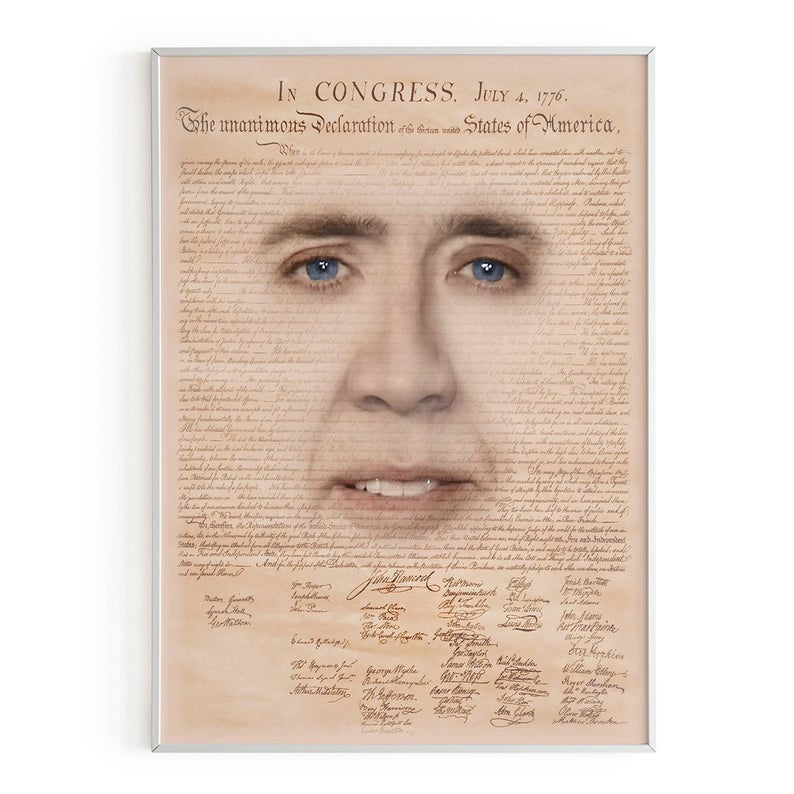




>  gdrive/My Drive/IA/demoConvNet-NC/Predict/president.jpg :  está Nicolas Cage


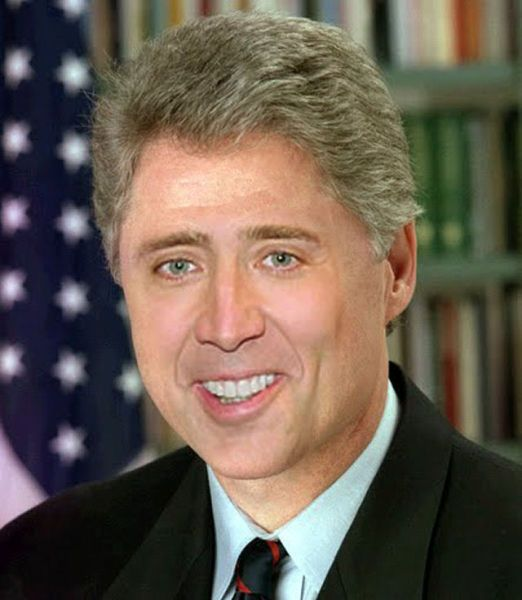




>  gdrive/My Drive/IA/demoConvNet-NC/Predict/shirt.jpg :  está Nicolas Cage


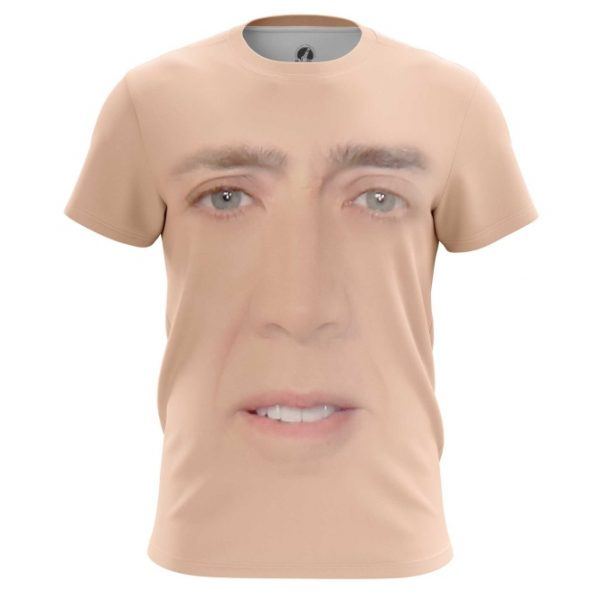




>  gdrive/My Drive/IA/demoConvNet-NC/Predict/sky.jpg :  NO está Nicolas Cage


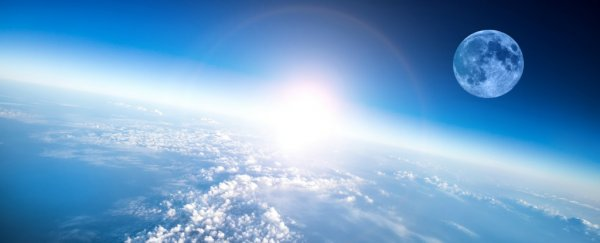




>  gdrive/My Drive/IA/demoConvNet-NC/Predict/old.jpg :  está Nicolas Cage


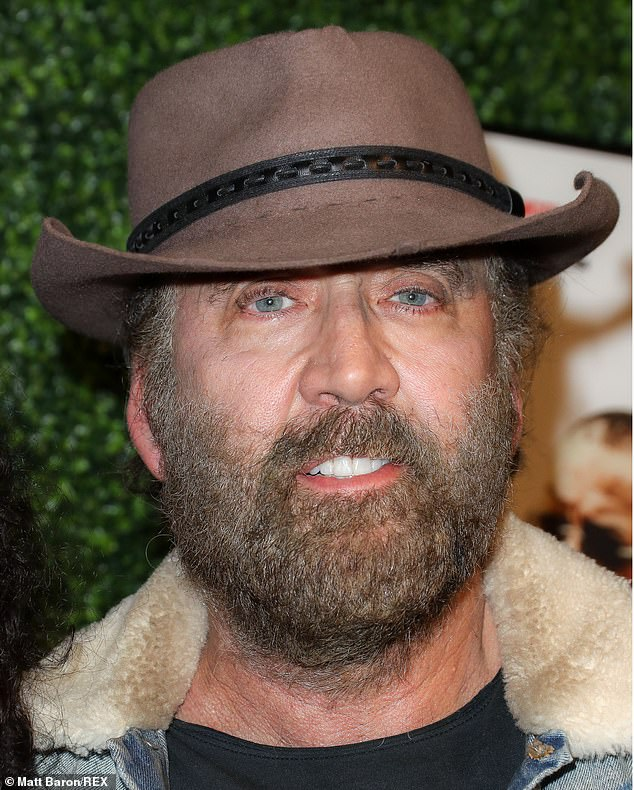




>  gdrive/My Drive/IA/demoConvNet-NC/Predict/picle.jpeg :  NO está Nicolas Cage


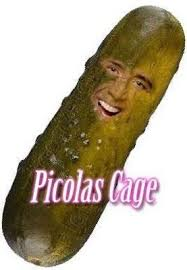




>  gdrive/My Drive/IA/demoConvNet-NC/Predict/rock.jpg :  NO está Nicolas Cage


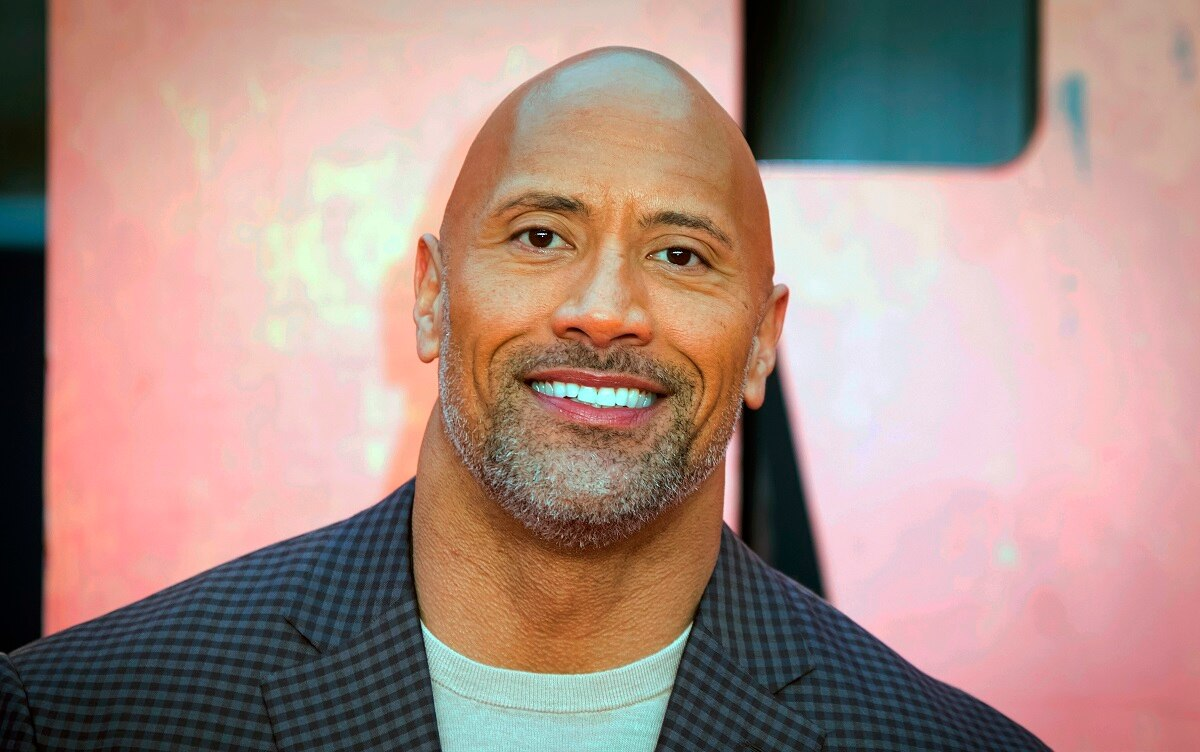




>  gdrive/My Drive/IA/demoConvNet-NC/Predict/three_cage.jpg :  está Nicolas Cage


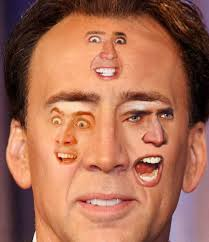




>  gdrive/My Drive/IA/demoConvNet-NC/Predict/137695.jpg :  NO está Nicolas Cage


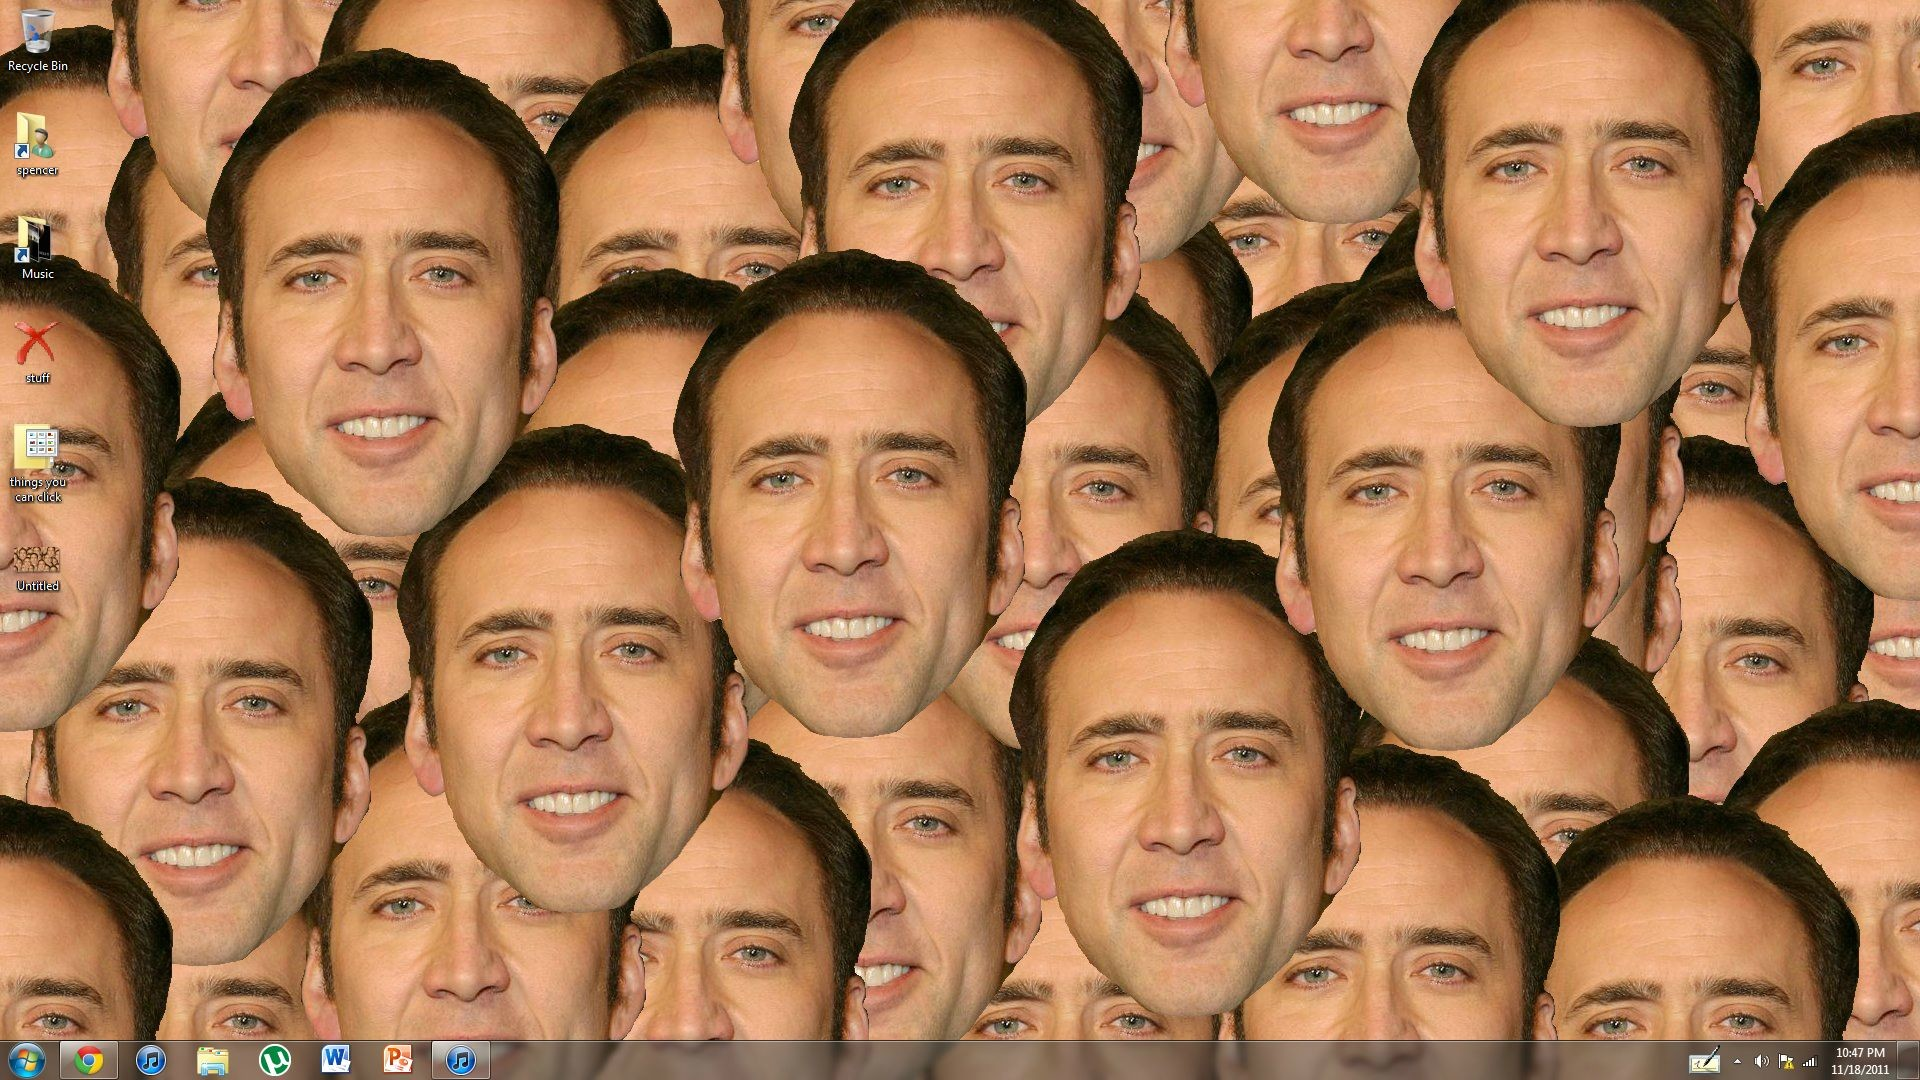




>  gdrive/My Drive/IA/demoConvNet-NC/Predict/badhair.jpg :  está Nicolas Cage


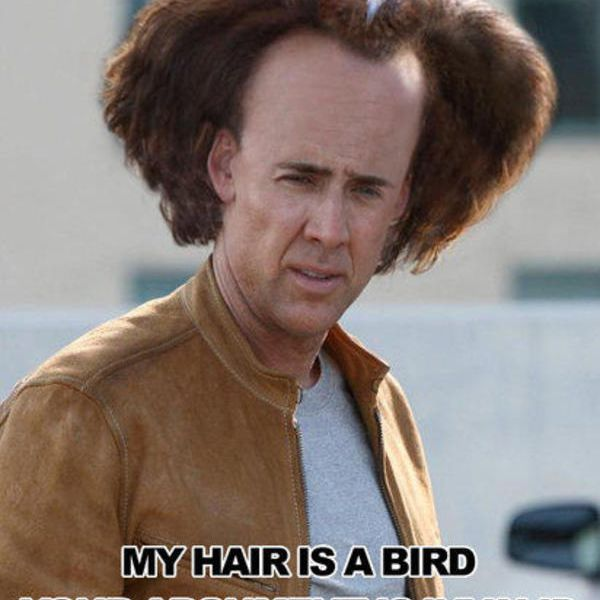




>  gdrive/My Drive/IA/demoConvNet-NC/Predict/beard.jpg :  está Nicolas Cage


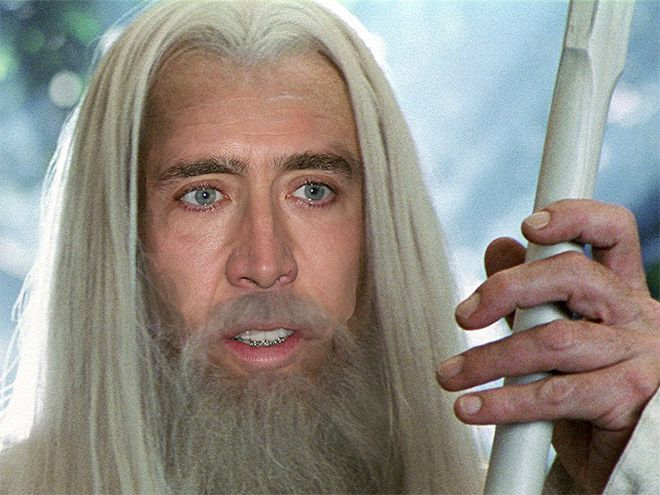




>  gdrive/My Drive/IA/demoConvNet-NC/Predict/forest.jpg :  NO está Nicolas Cage


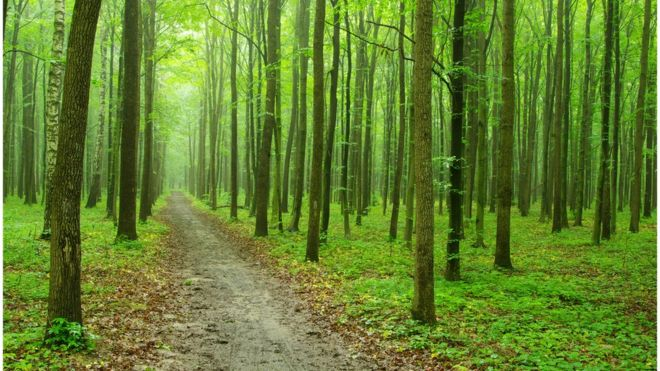

In [9]:
# define función auxiliar para mostrar resultado
def predict(file_name, image_sample):
    result = classifier.predict(image_sample)
    prediction = 'está Nicolas Cage' if result[0][0] == 1 else 'NO está Nicolas Cage'
    print("\n> ", file_name,": " , prediction)
    img = Image(file_name, width = "400", height = "400")
    display(img)
    print("\n")

# procesa las imágenes de la carpeta <Predict>
predict_path = "".join([path, '/Predict'])
for file in os.listdir(predict_path):
    if not file.startswith('.'):
        file = predict_path + "/" + file

        image_sample = image.load_img(file, target_size = (200, 200))
        image_sample = image.img_to_array(image_sample)
        image_sample = np.expand_dims(image_sample, axis = 0)
        
        predict(file, image_sample)